In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

## Import Data
<p>
Import data from csv and print head of df
<p>
Data dictionary in repo.

In [3]:
df_encoded_norm = pd.read_csv('ISM647_ML1_data_encoded.csv')

df_encoded_norm.head(10)

,target,AcctAge,DDA,DDABal,Checks,DirDep,NSF,NSFAmt,Teller,Sav,...,CRScore,Moved,InArea,Dep,DepAmt,Inv,InvBal,Res_R,Res_S,Res_U
0,1,0.000000,1,0.004282,0.000000,0,0,0.0,0.00,1,...,0.589404,0,1,0.071429,0.002413,0.0,0.000266,1,0,0
1,0,0.006536,1,0.009903,0.020408,1,0,0.0,0.00,0,...,0.516556,0,1,0.035714,0.000922,0.0,0.000266,1,0,0
2,1,0.062092,0,0.002778,0.000000,0,0,0.0,0.00,0,...,0.403974,0,1,0.000000,0.000000,0.0,0.000266,0,1,0
3,0,0.003268,1,0.008497,0.020408,0,0,0.0,0.04,1,...,0.509934,0,1,0.035714,0.002360,0.0,0.000266,0,1,0
4,1,0.104575,1,0.012867,0.040816,0,0,0.0,0.20,1,...,0.430464,0,1,0.071429,0.002493,0.0,0.000266,0,1,0
5,1,0.196078,1,0.006615,0.265306,1,0,0.0,0.36,0,...,0.476821,0,1,0.178571,0.014052,0.0,0.000266,0,0,1
6,0,0.138889,1,0.007933,0.244898,1,0,0.0,0.00,0,...,0.466887,0,1,0.071429,0.004615,0.0,0.000266,0,0,1
7,1,0.147059,1,0.008815,0.040816,1,0,0.0,0.00,1,...,0.519868,0,1,0.107143,0.001641,0.0,0.000266,0,0,1
8,1,0.009804,1,0.004436,0.081633,0,0,0.0,0.08,1,...,0.493377,0,1,0.071429,0.002165,0.0,0.000266,0,1,0
9,0,0.044118,1,0.009133,0.020408,1,0,0.0,0.04,0,...,0.311258,0,1,0.071429,0.002358,0.0,0.000266,0,0,1


In [4]:
# check for imbalanced data
df_encoded_norm['target'].value_counts()

target
0    13373
1     7504
Name: count, dtype: int64

## Create train, test, and validate data sets
<p>
70%, 20%, 10% split for Train, Validate, and Test

In [32]:
train, val, test = np.split(df_encoded_norm.sample(frac=1), [int(0.7*len(df_encoded_norm)), int(0.9*len(df_encoded_norm))])

c:\Users\nlofl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

14613 training examples
4176 validation examples
2088 test examples


## Address Imbalance in Training Data
<p>
Separate target from data set.
<p>
Address imbalance using the SMOTE method. (Synthetic Minority Oversample Technique)

In [34]:
# address imbalance in train data using SMOTE method
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
train_smote = train.drop('target', axis=1)
train_target = train['target']
train_smote, train_target = smote.fit_resample(train_smote, train_target)

print(train_smote.shape)
print(train_target.shape)

(18610, 44)
(18610,)


## Train a logistic regression model

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.layers import Dense, Dropout

# train the logistic regression model using keras
model = tf.keras.Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_smote.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# define the loss function and optimizer
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.75,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_focal_crossentropy'
)

In [36]:
# compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# train the model
history = model.fit(
    train_smote, train_target,
    validation_data=(val, val.pop('target')),
    batch_size=32,
    epochs=100,
    verbose=0
)

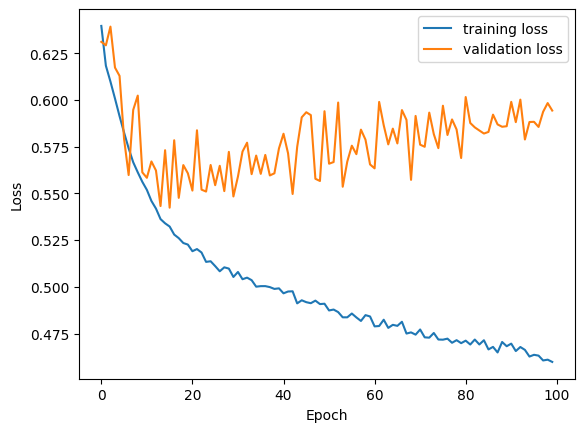

In [37]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


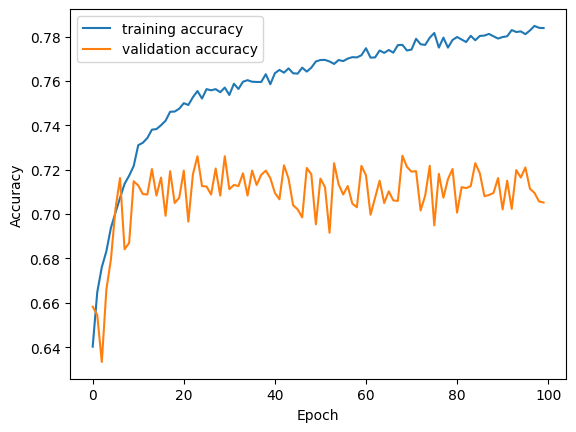

In [38]:
# plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [39]:

# evaluate the model on the test set
test_target = test.pop('target')
test_loss, test_accuracy = model.evaluate(test, test_target, verbose=0)

print(f'Test accuracy: {test_accuracy:.3f}')


Test accuracy: 0.703


66/66 [==============================] - 0s 687us/step


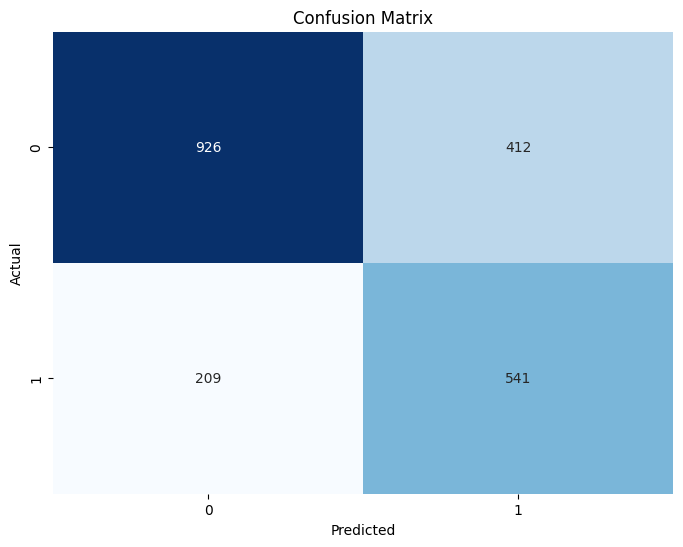

In [40]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict the test set as binary output
test_predictions = model.predict(test).round().astype(int)

# create confusion matrix
conf_matrix = confusion_matrix(test_target, test_predictions)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# create a classification report
from sklearn.metrics import classification_report

print(classification_report(test_target, test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1338
           1       0.57      0.72      0.64       750

    accuracy                           0.70      2088
   macro avg       0.69      0.71      0.69      2088
weighted avg       0.73      0.70      0.71      2088

